# 03 Análisis: Indicadores de Desarrollo vs Cambio Climático

En este notebook exploraremos cómo distintos indicadores de desarrollo (PIB, población, consumo de energía, participación de renovables, etc.) se relacionan con el cambio climático, medido a través de emisiones de CO₂ y de intensidad de carbono. Generaremos visualizaciones y métricas para evaluar el papel de las energías renovables en la mitigación de las emisiones.

**Actualización**: Ahora utilizamos datos de EDGAR 2024 para las emisiones de CO₂.

## Configuración Inicial

In [30]:
# Imports iniciales y configuración
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Función para matching de países
def find_country_matches(edgar_countries, other_countries):
    matches = {}
    
    # Coincidencias exactas
    for edgar_country in edgar_countries:
        if edgar_country in other_countries:
            matches[edgar_country] = edgar_country
    
    # Mapeo manual para casos especiales
    manual_mapping = {
        'Russia': 'Russian Federation',
        'Iran': 'Iran, Islamic Rep.',
        'South Korea': 'Korea, Rep.',
        'Turkey': 'Turkiye',
        'Egypt': 'Egypt, Arab Rep.',
        'Venezuela': 'Venezuela, RB',
        'United States': 'United States',
        'China': 'China',
        'India': 'India',
        'Germany': 'Germany',
        'Japan': 'Japan',
        'United Kingdom': 'United Kingdom',
        'France': 'France',
        'Italy': 'Italy',
        'Brazil': 'Brazil',
        'Canada': 'Canada',
        'Australia': 'Australia',
        'Spain': 'Spain',
        'Mexico': 'Mexico',
        'Indonesia': 'Indonesia'
    }
    
    # Aplicar mapeo manual
    for edgar_name, other_name in manual_mapping.items():
        if edgar_name in edgar_countries and other_name in other_countries:
            matches[edgar_name] = other_name
    
    return matches

## 1. Carga de datos

- **World Development Indicators** (`P_Data_Extract_From_World_Development_Indicators.xlsx`): múltiples indicadores por país y año.
- **PIB** (`API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls`): PIB total por país y año.
- **Emisiones de CO₂** (EDGAR 2024): datos actualizados de emisiones por país y año.

In [31]:
# 1. Desarrollo (WDI)
wdi_path = "../../data/fuentes/economicos/P_Data_Extract_From_World_Development_Indicators.xlsx"
xls_wdi  = pd.ExcelFile(wdi_path)
df_wdi   = xls_wdi.parse("Data")

print("Dataset WDI cargado:")
print(f"Dimensiones: {df_wdi.shape}")
display(df_wdi.head())

# 2. PIB
gdp_path = "../../data/fuentes/economicos/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls"
df_gdp   = pd.read_excel(gdp_path, skiprows=3)

print("\nDataset PIB cargado:")
print(f"Dimensiones: {df_gdp.shape}")
display(df_gdp.head())

# 3. Emisiones CO2 desde EDGAR 2024
co2_path = "../../data/fuentes/climaticos/EDGAR_2024_GHG_booklet_2024.xlsx"
df_co2   = pd.read_excel(co2_path, sheet_name='GHG_totals_by_country')

print("\nDataset EDGAR CO2 cargado:")
print(f"Dimensiones: {df_co2.shape}")
display(df_co2.head())
print("\nColumnas disponibles:")
display(df_co2.columns.tolist())

Dataset WDI cargado:
Dimensiones: (1601, 68)


,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,..,..,..,..,..,..,...,0.083662,0.086847,0.077308,0.081098,0.076226,0.067211,0.050538,0.06575,0.070581,..
1,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per constant ...,EN.GHG.CO2.RT.GDP.KD,..,..,..,..,..,..,...,0.438997,0.455707,0.405653,0.425544,0.399975,0.352672,0.265188,0.345006,0.370357,..
2,Afghanistan,AFG,"Electricity production from oil, gas and coal ...",EG.ELC.FOSL.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.KH,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..



Dataset PIB cargado:
Dimensiones: (266, 69)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.481857e+09,2.929447e+09,3.279344e+09,3.648573e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.421063e+10,2.496398e+10,2.707880e+10,3.177575e+10,3.028579e+10,3.381317e+10,...,8.982778e+11,8.289428e+11,9.729989e+11,1.012306e+12,1.009721e+12,9.333918e+11,1.085745e+12,1.191423e+12,1.245472e+12,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.190495e+10,1.270788e+10,1.363076e+10,1.446909e+10,1.580376e+10,1.692109e+10,...,7.717669e+11,6.943610e+11,6.878492e+11,7.704950e+11,8.264838e+11,7.898017e+11,8.493124e+11,8.839739e+11,7.991060e+11,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10,NaN



Dataset EDGAR CO2 cargado:
Dimensiones: (214, 56)


,EDGAR Country Code,Country,1970,1971,1972,1973,1974,1975,1976,1977,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ABW,Aruba,0.036713,0.041538,0.052391,0.057360,0.056630,0.070743,0.069793,0.080624,...,0.469468,0.490990,0.514539,0.496141,0.495532,0.588998,0.482160,0.531202,0.533603,0.561498
1,AFG,Afghanistan,15.437430,15.364077,13.316628,13.934875,15.177862,15.843058,15.943325,16.088215,...,27.420132,27.408332,26.633999,27.691927,27.553282,26.982777,26.646320,27.643074,28.614071,29.460052
2,AGO,Angola,18.998763,18.866057,21.459002,23.018941,23.685423,22.519608,18.586243,23.251029,...,77.295699,81.775031,78.875889,73.424409,69.504638,69.910832,61.680081,64.408994,67.210842,67.700756
3,AIA,Anguilla,0.003355,0.003396,0.003534,0.003411,0.003694,0.003968,0.003833,0.003960,...,0.031210,0.031334,0.031728,0.032476,0.031594,0.030948,0.026037,0.025224,0.025068,0.026211
4,AIR,International Aviation,172.478021,172.465452,182.459819,190.296910,183.162104,177.165836,177.483077,193.593366,...,514.263976,543.354255,567.631287,597.771580,624.135612,633.464502,302.632337,335.728729,416.953422,498.178114



Columnas disponibles:


['EDGAR Country Code',
 'Country',
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

## 2. Transformación a formato "long"

Normalizamos columnas y pivotamos cada dataset de formato ancho a largo.

In [32]:
# Transformar WDI a formato largo
year_cols = [c for c in df_wdi.columns if c.endswith("]")]
df_dev_long = (
    df_wdi
      .melt(
         id_vars=["Country Name","Country Code","Series Name","Series Code"],
         value_vars=year_cols,
         var_name="Year",
         value_name="Value"
       )
)
df_dev_long["Year"] = df_dev_long["Year"].str.extract(r"(\d{4})").astype(int)
df_dev_long["Value"] = pd.to_numeric(df_dev_long["Value"], errors="coerce")

print("Dataset WDI en formato largo:")
print(f"Dimensiones: {df_dev_long.shape}")
display(df_dev_long.head())

Dataset WDI en formato largo:
Dimensiones: (102464, 6)


,Country Name,Country Code,Series Name,Series Code,Year,Value
0,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,1960,NaN
1,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per constant ...,EN.GHG.CO2.RT.GDP.KD,1960,NaN
2,Afghanistan,AFG,"Electricity production from oil, gas and coal ...",EG.ELC.FOSL.ZS,1960,NaN
3,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.ZS,1960,NaN
4,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.KH,1960,NaN


In [33]:
# Transformar PIB a formato largo
year_cols_gdp = [c for c in df_gdp.columns if str(c).isdigit()]
df_gdp_long = (
    df_gdp
      .melt(
         id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
         value_vars=year_cols_gdp,
         var_name="Year",
         value_name="GDP"
       )
      .dropna(subset=["GDP"])
)
df_gdp_long["Year"] = df_gdp_long["Year"].astype(int)
df_gdp_long["GDP"]  = pd.to_numeric(df_gdp_long["GDP"], errors="coerce")

print("Dataset PIB en formato largo:")
print(f"Dimensiones: {df_gdp_long.shape}")
display(df_gdp_long.head())

Dataset PIB en formato largo:
Dimensiones: (14307, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1960,2.421063e+10
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1960,1.190495e+10
13,Australia,AUS,GDP (current US$),NY.GDP.MKTP.CD,1960,1.860768e+10
14,Austria,AUT,GDP (current US$),NY.GDP.MKTP.CD,1960,6.624086e+09
16,Burundi,BDI,GDP (current US$),NY.GDP.MKTP.CD,1960,1.960000e+08


In [34]:
# Transformar datos de EDGAR CO2 a formato largo
print("Procesando datos de EDGAR CO2...")

# Identificar columnas de años
year_columns = [col for col in df_co2.columns if str(col).replace('.', '').isdigit()]
print(f"Columnas de años encontradas: {len(year_columns)} desde {min(year_columns) if year_columns else 'N/A'} hasta {max(year_columns) if year_columns else 'N/A'}")

# Identificar columnas de identificación
id_vars = [col for col in df_co2.columns if col not in year_columns]
print(f"Columnas de identificación: {id_vars}")

# Transformar a formato largo
df_co2_long = pd.melt(
    df_co2,
    id_vars=id_vars,
    value_vars=year_columns,
    var_name='Year',
    value_name='CO2'
)

# Limpiar y convertir datos
df_co2_long['Year'] = pd.to_numeric(df_co2_long['Year'], errors='coerce')
df_co2_long['CO2'] = pd.to_numeric(df_co2_long['CO2'], errors='coerce')

# Eliminar valores nulos
df_co2_clean = df_co2_long.dropna(subset=['CO2', 'Year'])

# Renombrar columna de país
df_co2_clean = df_co2_clean.rename(columns={'Country': 'Country Name'})

print(f"\nDataset CO2 procesado: {df_co2_clean.shape[0]} observaciones")
print(f"Rango de años: {df_co2_clean['Year'].min()} - {df_co2_clean['Year'].max()}")
print(f"Países únicos: {df_co2_clean['Country Name'].nunique()}")
display(df_co2_clean.head())

Procesando datos de EDGAR CO2...
Columnas de años encontradas: 54 desde 1970 hasta 2023
Columnas de identificación: ['EDGAR Country Code', 'Country']

Dataset CO2 procesado: 11448 observaciones
Rango de años: 1970 - 2023
Países únicos: 212


,EDGAR Country Code,Country Name,Year,CO2
0,ABW,Aruba,1970,0.036713
1,AFG,Afghanistan,1970,15.437430
2,AGO,Angola,1970,18.998763
3,AIA,Anguilla,1970,0.003355
4,AIR,International Aviation,1970,172.478021


## 3. Selección de indicadores clave

Nos interesa evaluar:
- **Energías renovables**:
  - `EG.ELC.RNWX.ZS` (% electricidad renovable)
  - `EG.ELC.FOSL.ZS` (% electricidad fósil)
- **Consumo energético**:
  - `EG.USE.PCAP.KG.OE` (kg petróleo eq. per cápita)
- **Intensidad de carbono**:
  - `EN.GHG.CO2.RT.GDP.KD` (kg CO₂ por US$ constante)
  - `EN.GHG.CO2.RT.GDP.PP.KD` (kg CO₂ por US$ PPA)

In [35]:
# Filtrar indicadores de interés
indic_codes = [
  "EG.ELC.RNWX.ZS","EG.ELC.FOSL.ZS",
  "EG.USE.PCAP.KG.OE",
  "EN.GHG.CO2.RT.GDP.KD","EN.GHG.CO2.RT.GDP.PP.KD"
]

# Verificar qué indicadores están disponibles
available_codes = df_dev_long['Series Code'].unique()
print("Indicadores solicitados:")
for code in indic_codes:
    if code in available_codes:
        count = df_dev_long[df_dev_long['Series Code'] == code].shape[0]
        print(f"✓ {code} - {count} registros")
    else:
        print(f"✗ {code} - No disponible")

# Filtrar solo los indicadores disponibles
available_indic_codes = [code for code in indic_codes if code in available_codes]
df_ind = df_dev_long[df_dev_long["Series Code"].isin(available_indic_codes)].copy()

print(f"\nIndicadores filtrados: {len(available_indic_codes)}")
print(f"Registros: {df_ind.shape[0]}")
display(df_ind.head())

Indicadores solicitados:
✓ EG.ELC.RNWX.ZS - 17024 registros
✓ EG.ELC.FOSL.ZS - 17024 registros
✗ EG.USE.PCAP.KG.OE - No disponible
✓ EN.GHG.CO2.RT.GDP.KD - 17024 registros
✓ EN.GHG.CO2.RT.GDP.PP.KD - 17024 registros

Indicadores filtrados: 4
Registros: 68096


,Country Name,Country Code,Series Name,Series Code,Year,Value
0,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,1960,NaN
1,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per constant ...,EN.GHG.CO2.RT.GDP.KD,1960,NaN
2,Afghanistan,AFG,"Electricity production from oil, gas and coal ...",EG.ELC.FOSL.ZS,1960,NaN
3,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.ZS,1960,NaN
6,Albania,ALB,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,1960,NaN


## 4. Pivot a formato ancho

Creamos un DataFrame con una columna por indicador, índice por país y año.

In [36]:
# Pivot indicadores a formato ancho
df_wide = (
    df_ind
      .pivot_table(
         index=["Country Name","Country Code","Year"],
         columns="Series Code",
         values="Value"
      )
      .reset_index()
)

# Renombrar columnas para facilitar el análisis
column_mapping = {
    "EG.ELC.RNWX.ZS":    "pct_renovables",
    "EG.ELC.FOSL.ZS":    "pct_fosiles",
    "EG.USE.PCAP.KG.OE": "uso_energia_pc",
    "EN.GHG.CO2.RT.GDP.KD":   "intensidad_constante",
    "EN.GHG.CO2.RT.GDP.PP.KD":"intensidad_ppa"
}

# Aplicar solo los renombramientos para columnas que existen
existing_columns = {k: v for k, v in column_mapping.items() if k in df_wide.columns}
df_wide = df_wide.rename(columns=existing_columns)

print("Dataset en formato ancho:")
print(f"Dimensiones: {df_wide.shape}")
print(f"Columnas: {df_wide.columns.tolist()}")
display(df_wide.head())

Dataset en formato ancho:
Dimensiones: (12662, 7)
Columnas: ['Country Name', 'Country Code', 'Year', 'pct_fosiles', 'pct_renovables', 'intensidad_constante', 'intensidad_ppa']


Series Code,Country Name,Country Code,Year,pct_fosiles,pct_renovables,intensidad_constante,intensidad_ppa
0,Afghanistan,AFG,2000,NaN,NaN,0.172592,0.032892
1,Afghanistan,AFG,2001,NaN,NaN,0.175818,0.033507
2,Afghanistan,AFG,2002,NaN,NaN,0.134587,0.025649
3,Afghanistan,AFG,2003,NaN,NaN,0.134583,0.025648
4,Afghanistan,AFG,2004,NaN,NaN,0.117716,0.022434


## 5. Unión de todos los datos

Fusionamos:
1. **df_wide** (indicadores de desarrollo)
2. **df_gdp_long** (PIB)
3. **df_co2_clean** (emisiones CO2 desde EDGAR)
en un solo DataFrame para análisis conjunto.

In [37]:
# Preparar datasets para fusión
df_gdp_sub = df_gdp_long[["Country Name","Country Code","Year","GDP"]].copy()
df_co2_sub = df_co2_clean[["Country Name","Year","CO2"]].copy()

print("Preparando fusión de datos...")
print(f"Indicadores: {df_wide.shape[0]} registros, {df_wide['Country Name'].nunique()} países")
print(f"PIB: {df_gdp_sub.shape[0]} registros, {df_gdp_sub['Country Name'].nunique()} países")
print(f"CO2: {df_co2_sub.shape[0]} registros, {df_co2_sub['Country Name'].nunique()} países")

# Crear mapeo de países para CO2 (EDGAR) con otros datasets
paises_edgar = df_co2_sub['Country Name'].unique()
paises_otros = df_wide['Country Name'].unique()

country_mapping = find_country_matches(paises_edgar, paises_otros)
print(f"\nPaíses con mapeo exitoso: {len(country_mapping)}")

# Aplicar mapeo al dataset de CO2
df_co2_mapped = df_co2_sub.copy()
df_co2_mapped['Country Name Mapped'] = df_co2_mapped['Country Name'].map(country_mapping)
df_co2_mapped = df_co2_mapped[df_co2_mapped['Country Name Mapped'].notna()]

print(f"Registros CO2 con mapeo: {df_co2_mapped.shape[0]}")

# Fusionar en cadena
df_all = (
    df_wide
      .merge(df_gdp_sub, on=["Country Name","Country Code","Year"], how="inner")
      .merge(df_co2_mapped[['Country Name Mapped', 'Year', 'CO2']], 
             left_on=["Country Name","Year"], 
             right_on=["Country Name Mapped","Year"], 
             how="inner")
)

print(f"\nDataset final fusionado: {df_all.shape[0]} observaciones")
print(f"Países con datos completos: {df_all['Country Name'].nunique()}")
if df_all.shape[0] > 0:
    print(f"Rango de años: {df_all['Year'].min()} - {df_all['Year'].max()}")
    display(df_all.head())
    
    # Mostrar disponibilidad de datos por columna
    print("\nDisponibilidad de datos:")
    for col in ['pct_renovables', 'pct_fosiles', 'GDP', 'CO2']:
        if col in df_all.columns:
            non_null = df_all[col].notna().sum()
            print(f"  {col}: {non_null} valores no nulos")
else:
    print("\nNo se pudieron fusionar los datos. Verificando...")
    print(f"Países comunes entre indicadores y PIB: {len(set(df_wide['Country Name']) & set(df_gdp_sub['Country Name']))}")
    print(f"Países mapeados de CO2: {len(country_mapping)}")

Preparando fusión de datos...
Indicadores: 12662 registros, 255 países
PIB: 14307 registros, 262 países
CO2: 11448 registros, 212 países

Países con mapeo exitoso: 167
Registros CO2 con mapeo: 9018

Dataset final fusionado: 7879 observaciones
Países con datos completos: 166
Rango de años: 1970 - 2022


,Country Name,Country Code,Year,pct_fosiles,pct_renovables,intensidad_constante,intensidad_ppa,GDP,Country Name Mapped,CO2
0,Afghanistan,AFG,2000,NaN,NaN,0.172592,0.032892,3.521418e+09,Afghanistan,13.915672
1,Afghanistan,AFG,2001,NaN,NaN,0.175818,0.033507,2.813572e+09,Afghanistan,12.206456
2,Afghanistan,AFG,2002,NaN,NaN,0.134587,0.025649,3.825701e+09,Afghanistan,14.756988
3,Afghanistan,AFG,2003,NaN,NaN,0.134583,0.025648,4.520947e+09,Afghanistan,15.337134
4,Afghanistan,AFG,2004,NaN,NaN,0.117716,0.022434,5.224897e+09,Afghanistan,15.297465



Disponibilidad de datos:
  pct_renovables: 4685 valores no nulos
  pct_fosiles: 4685 valores no nulos
  GDP: 7879 valores no nulos
  CO2: 7879 valores no nulos


## 6. Gráfica 1: % Renovables vs Emisiones de CO2

Visualizamos la relación entre la penetración de renovables y las emisiones de CO₂ en el año más reciente con datos completos.

Dataset fusionado exitosamente: 7879 observaciones, 166 países
  pct_renovables: 4685 valores disponibles
  CO2: 7879 valores disponibles
  GDP: 7879 valores disponibles

Año seleccionado para análisis: 2000 (118 países con datos de renovables)
Países con datos completos para gráfico: 118


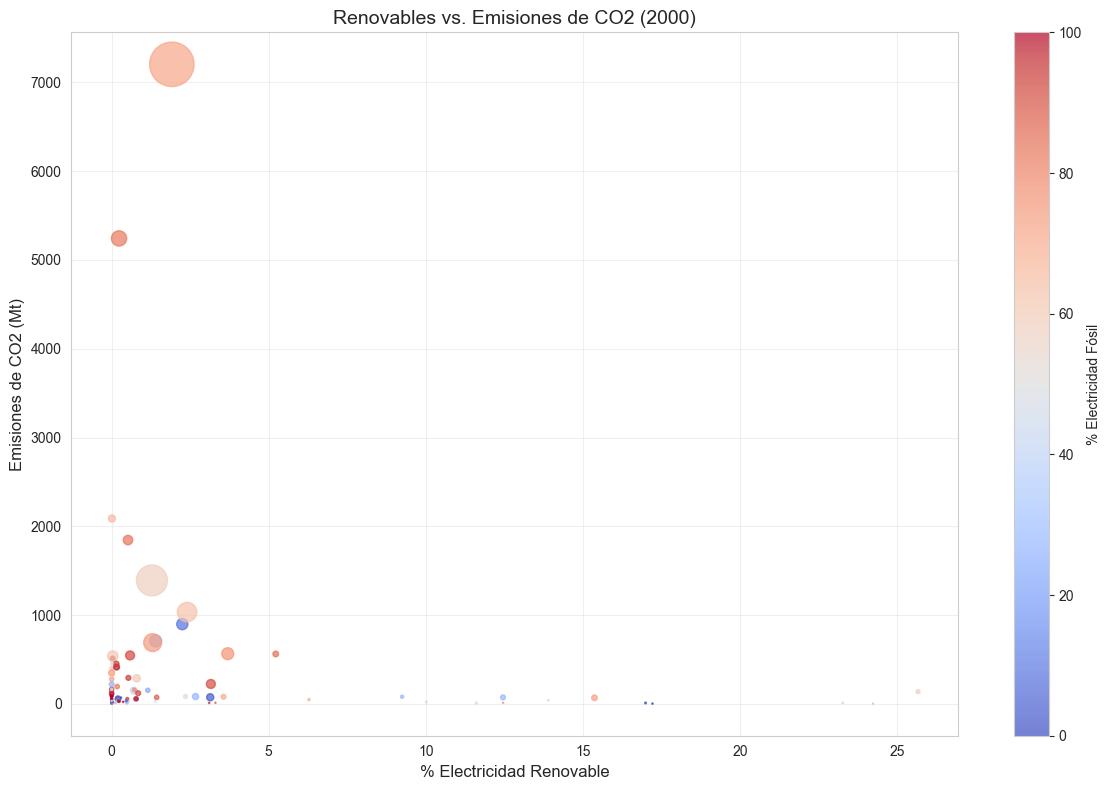

Correlación % Renovables vs CO2: -0.056

Países con mayor % de renovables:
  Philippines: 25.7% renovables, 138.3 Mt CO2
  Mauritius: 24.2% renovables, 3.2 Mt CO2
  El Salvador: 23.3% renovables, 10.4 Mt CO2
  Iceland: 17.2% renovables, 3.9 Mt CO2
  Costa Rica: 17.0% renovables, 11.0 Mt CO2


In [38]:
# Análisis de renovables vs emisiones
if df_all.shape[0] > 0:
    print(f"Dataset fusionado exitosamente: {df_all.shape[0]} observaciones, {df_all['Country Name'].nunique()} países")
    
    # Verificar disponibilidad de columnas clave
    key_cols = ['pct_renovables', 'CO2', 'GDP']
    available_data = {}
    for col in key_cols:
        if col in df_all.columns:
            non_null_count = df_all[col].notna().sum()
            available_data[col] = non_null_count
            print(f"  {col}: {non_null_count} valores disponibles")
    
    # Encontrar el mejor año para análisis (con más datos de renovables)
    if 'pct_renovables' in df_all.columns and 'CO2' in df_all.columns:
        # Contar países con datos de renovables por año
        year_renewable_counts = df_all[df_all['pct_renovables'].notna()].groupby('Year').size()
        
        if len(year_renewable_counts) > 0:
            best_year = year_renewable_counts.idxmax()
            print(f"\nAño seleccionado para análisis: {best_year} ({year_renewable_counts[best_year]} países con datos de renovables)")
            
            # Filtrar datos para el año seleccionado
            df_plot = df_all[df_all['Year'] == best_year].copy()
            
            # Usar todos los datos disponibles, no solo los que tienen renovables
            df_plot_renovables = df_plot[df_plot['pct_renovables'].notna() & df_plot['CO2'].notna()]
            
            if df_plot_renovables.shape[0] > 0:
                print(f"Países con datos completos para gráfico: {df_plot_renovables.shape[0]}")
                
                # Crear gráfico
                plt.figure(figsize=(12, 8))
                
                # Preparar datos para scatter
                x_data = df_plot_renovables['pct_renovables']
                y_data = df_plot_renovables['CO2']
                
                # Tamaño basado en GDP (si está disponible)
                if 'GDP' in df_plot_renovables.columns and df_plot_renovables['GDP'].notna().sum() > 0:
                    sizes = df_plot_renovables['GDP'] / 1e10  # Escalar GDP
                    sizes = sizes.fillna(50)  # Tamaño por defecto para valores nulos
                else:
                    sizes = 50
                
                # Color basado en % fósiles (si está disponible)
                if 'pct_fosiles' in df_plot_renovables.columns and df_plot_renovables['pct_fosiles'].notna().sum() > 0:
                    colors = df_plot_renovables['pct_fosiles']
                    scatter = plt.scatter(x_data, y_data, s=sizes, c=colors, cmap='coolwarm', alpha=0.7)
                    plt.colorbar(scatter, label='% Electricidad Fósil')
                else:
                    scatter = plt.scatter(x_data, y_data, s=sizes, c='blue', alpha=0.7)
                
                plt.xlabel('% Electricidad Renovable', fontsize=12)
                plt.ylabel('Emisiones de CO2 (Mt)', fontsize=12)
                plt.title(f'Renovables vs. Emisiones de CO2 ({best_year})', fontsize=14)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                # Mostrar estadísticas
                corr = x_data.corr(y_data)
                print(f"Correlación % Renovables vs CO2: {corr:.3f}")
                
                # Mostrar algunos países destacados
                print("\nPaíses con mayor % de renovables:")
                top_renewable = df_plot_renovables.nlargest(5, 'pct_renovables')[['Country Name', 'pct_renovables', 'CO2']]
                for _, row in top_renewable.iterrows():
                    print(f"  {row['Country Name']}: {row['pct_renovables']:.1f}% renovables, {row['CO2']:.1f} Mt CO2")
                    
            else:
                print(f"No hay datos válidos para el año {best_year}")
        else:
            print("No hay datos de renovables disponibles")
    else:
        print("Faltan columnas clave para el análisis")
        print(f"Columnas disponibles: {df_all.columns.tolist()}")
else:
    print("No hay datos fusionados disponibles para el análisis")

## 7. Gráfica 2: Evolución temporal de renovables y emisiones globales

Comparamos la evolución media anual de:
- **% de electricidad renovable** (`pct_renovables`)
- **% de electricidad fósil** (`pct_fosiles`)
- **Emisiones globales de CO₂** (`CO2`)

Calculando tendencias temporales...
Datos de renovables: 53 años
Datos de fósiles: 53 años
Datos de CO2: 53 años


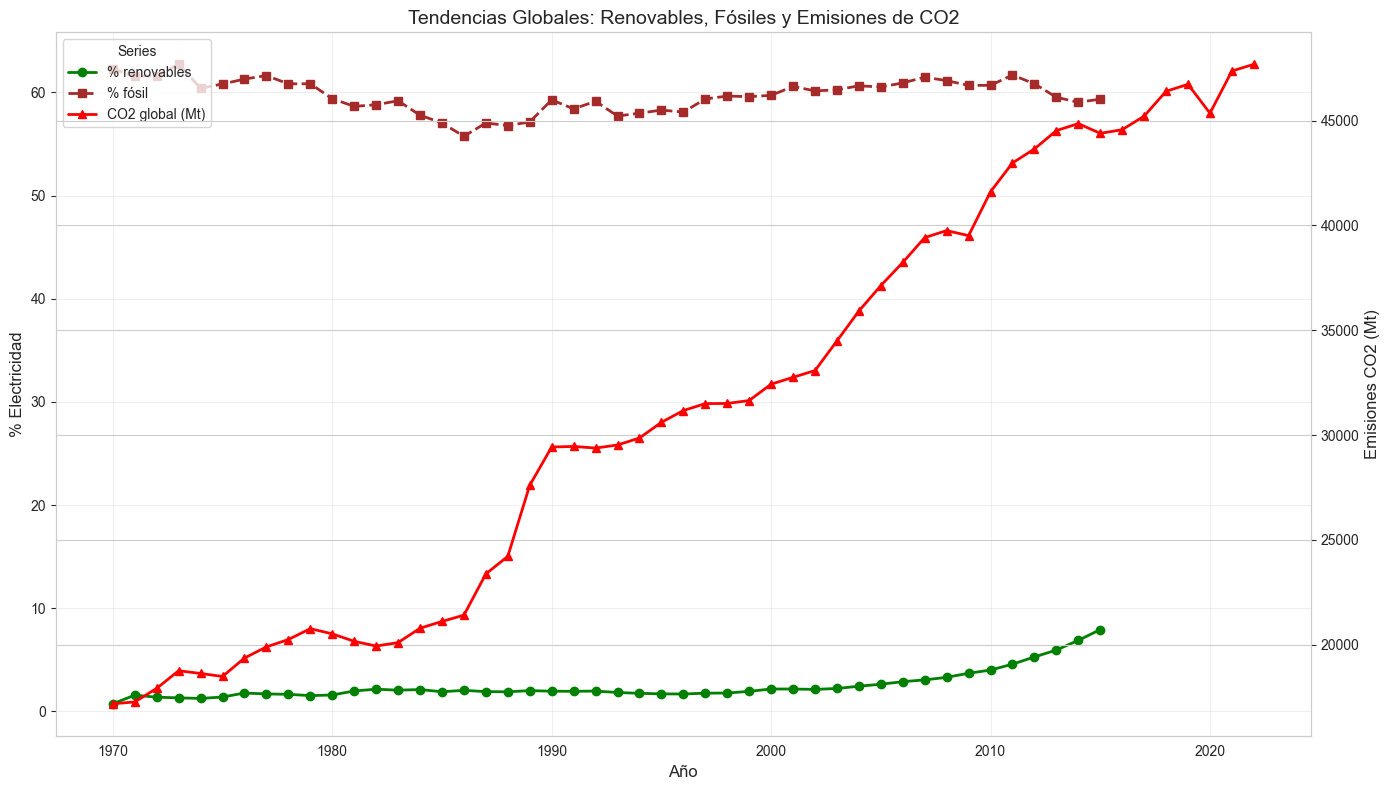


Tendencias identificadas:
renovables: nan unidades/año
fosiles: nan unidades/año
co2_global: 647.195 unidades/año


In [39]:
# Evolución temporal
if df_all.shape[0] > 0:
    print("Calculando tendencias temporales...")
    
    # Calcular tendencias anuales
    trends = {}
    
    if 'pct_renovables' in df_all.columns:
        trends['renovables'] = df_all.groupby("Year")["pct_renovables"].mean().reset_index()
        print(f"Datos de renovables: {len(trends['renovables'])} años")
    
    if 'pct_fosiles' in df_all.columns:
        trends['fosiles'] = df_all.groupby("Year")["pct_fosiles"].mean().reset_index()
        print(f"Datos de fósiles: {len(trends['fosiles'])} años")
    
    if 'CO2' in df_all.columns:
        trends['co2_global'] = df_all.groupby("Year")["CO2"].sum().reset_index()
        print(f"Datos de CO2: {len(trends['co2_global'])} años")
    
    if len(trends) > 0:
        # Configurar gráfico con doble eje
        fig, ax1 = plt.subplots(figsize=(14,8))
        ax2 = ax1.twinx()
        
        # Dibujar series de energía en el eje izquierdo
        if 'renovables' in trends and len(trends['renovables']) > 0:
            ax1.plot(trends['renovables']['Year'], trends['renovables']['pct_renovables'], 
                    label="% renovables", color="green", linewidth=2, marker='o')
        
        if 'fosiles' in trends and len(trends['fosiles']) > 0:
            ax1.plot(trends['fosiles']['Year'], trends['fosiles']['pct_fosiles'], 
                    label="% fósil", color="brown", linewidth=2, linestyle="--", marker='s')
        
        # Dibujar emisiones en el eje derecho
        if 'co2_global' in trends and len(trends['co2_global']) > 0:
            ax2.plot(trends['co2_global']['Year'], trends['co2_global']['CO2'], 
                    label="CO2 global (Mt)", color="red", linewidth=2, marker='^')
        
        # Configurar ejes y etiquetas
        ax1.set_xlabel("Año", fontsize=12)
        ax1.set_ylabel("% Electricidad", fontsize=12)
        ax2.set_ylabel("Emisiones CO2 (Mt)", fontsize=12)
        ax1.set_title("Tendencias Globales: Renovables, Fósiles y Emisiones de CO2", fontsize=14)
        
        # Combinar leyendas
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                  loc="upper left", title="Series")
        
        ax1.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Mostrar estadísticas de tendencia
        print("\nTendencias identificadas:")
        for name, data in trends.items():
            if len(data) > 1:
                col_name = [c for c in data.columns if c != 'Year'][0]
                trend = np.polyfit(data['Year'], data[col_name], 1)[0]
                print(f"{name}: {trend:.3f} unidades/año")
    else:
        print("No hay datos suficientes para mostrar tendencias temporales")
else:
    print("No hay datos disponibles para el análisis temporal")

## 8. Gráfica 3: Matriz de correlación

Calculamos la correlación entre las variables clave para identificar relaciones fuertes.

Columnas para análisis de correlación: ['pct_renovables', 'pct_fosiles', 'intensidad_constante', 'intensidad_ppa', 'GDP', 'CO2']


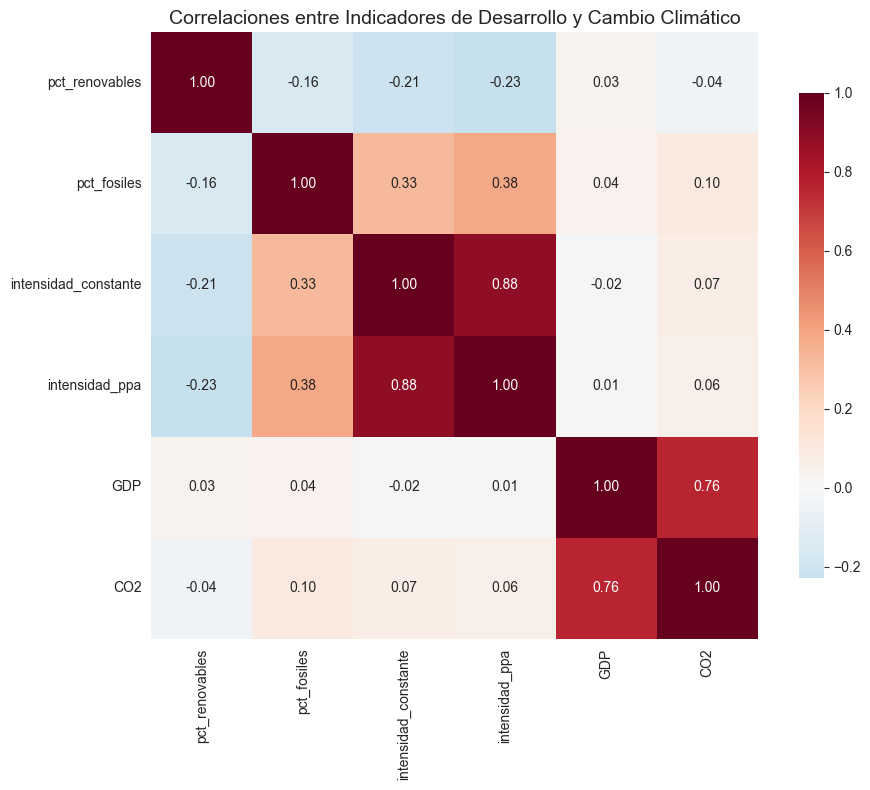


Correlaciones más fuertes (|r| > 0.5):
intensidad_constante vs intensidad_ppa: 0.881
GDP vs CO2: 0.763


In [40]:
# Matriz de correlación
if df_all.shape[0] > 0:
    # Identificar columnas numéricas disponibles
    potential_cols = [
        "pct_renovables",
        "pct_fosiles",
        "uso_energia_pc",
        "intensidad_constante",
        "intensidad_ppa",
        "GDP",
        "CO2"
    ]
    
    # Filtrar solo las columnas que existen y tienen datos
    corr_cols = []
    for col in potential_cols:
        if col in df_all.columns and df_all[col].notna().sum() > 10:
            corr_cols.append(col)
    
    print(f"Columnas para análisis de correlación: {corr_cols}")
    
    if len(corr_cols) >= 2:
        # Calcular matriz de correlaciones
        corr = df_all[corr_cols].corr()
        
        # Dibujar heatmap
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                   square=True, cbar_kws={"shrink": .8})
        plt.title("Correlaciones entre Indicadores de Desarrollo y Cambio Climático", fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Mostrar correlaciones más fuertes
        print("\nCorrelaciones más fuertes (|r| > 0.5):")
        for i in range(len(corr.columns)):
            for j in range(i+1, len(corr.columns)):
                corr_val = corr.iloc[i, j]
                if abs(corr_val) > 0.5:
                    print(f"{corr.columns[i]} vs {corr.columns[j]}: {corr_val:.3f}")
    else:
        print("No hay suficientes columnas numéricas para el análisis de correlación")
else:
    print("No hay datos disponibles para el análisis de correlación")

## 9. Análisis Adicional: Países Líderes en Renovables

Identificamos los países con mayor penetración de energías renovables y analizamos sus emisiones.

Top 15 países por % de electricidad renovable (promedio):


,pct_renovables,CO2,GDP
Country Name,,,
El Salvador,24.854999,9.226282,1.136728e+10
Nicaragua,18.234191,12.726883,5.599089e+09
Mauritius,15.897600,2.969045,5.426065e+09
Philippines,15.728164,136.067409,1.243647e+11
Kenya,15.728034,50.382193,2.737861e+10
Denmark,12.308667,69.187955,1.857697e+11
Iceland,11.150971,4.197526,1.009378e+10
Guatemala,10.557395,20.806398,2.617262e+10
New Zealand,9.701181,75.708666,8.602639e+10


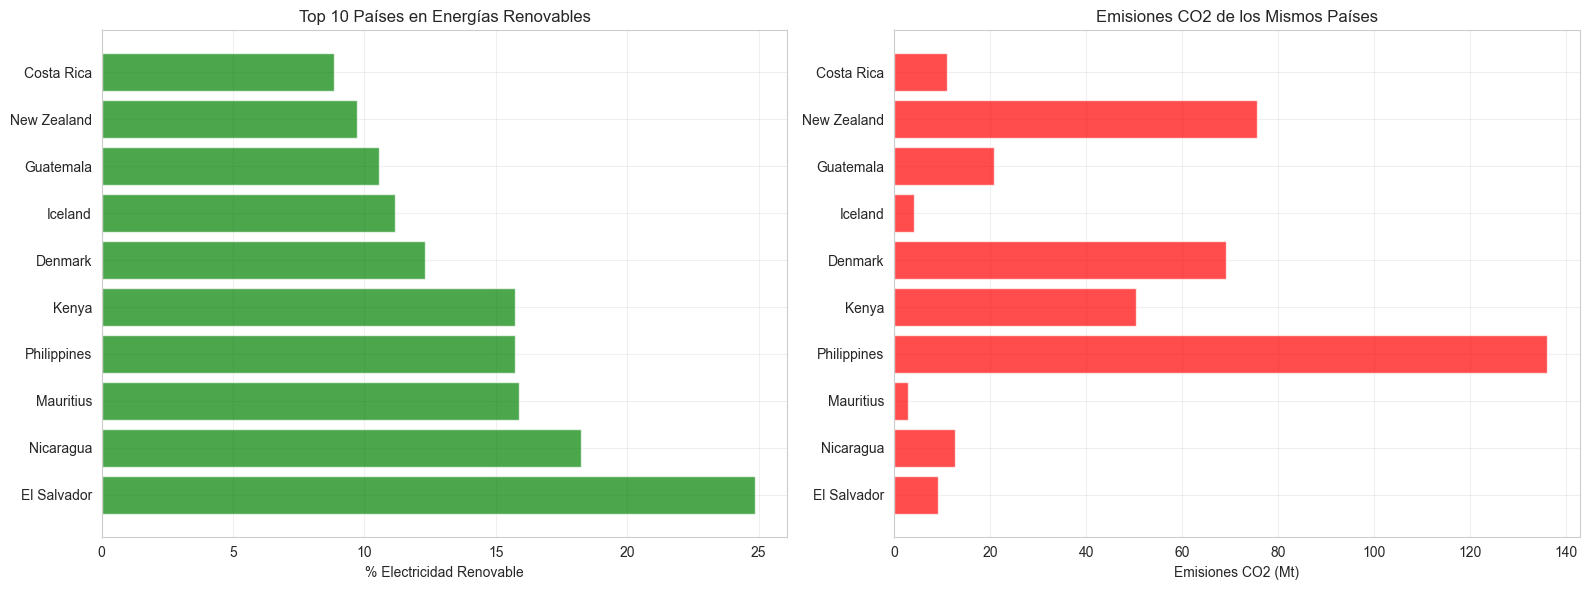


Estadísticas de países líderes en renovables:
Promedio % renovables: 14.3%
Promedio emisiones CO2: 39.2 Mt

Comparación con promedio global:
Promedio global % renovables: 2.6%
Promedio global emisiones CO2: 210.7 Mt


In [41]:
# Análisis de países líderes en renovables
if df_all.shape[0] > 0 and 'pct_renovables' in df_all.columns:
    # Calcular promedio de renovables por país
    paises_renovables = (
        df_all.groupby('Country Name')
        .agg({
            'pct_renovables': 'mean',
            'CO2': 'mean',
            'GDP': 'mean'
        })
        .dropna(subset=['pct_renovables'])  # Solo países con datos de renovables
        .sort_values('pct_renovables', ascending=False)
    )
    
    print("Top 15 países por % de electricidad renovable (promedio):")
    display(paises_renovables.head(15))
    
    # Gráfico de barras de top 10
    top_10_renovables = paises_renovables.head(10)
    
    if len(top_10_renovables) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Gráfico 1: % Renovables
        ax1.barh(range(len(top_10_renovables)), top_10_renovables['pct_renovables'], color='green', alpha=0.7)
        ax1.set_yticks(range(len(top_10_renovables)))
        ax1.set_yticklabels(top_10_renovables.index, fontsize=10)
        ax1.set_xlabel('% Electricidad Renovable')
        ax1.set_title('Top 10 Países en Energías Renovables')
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Emisiones CO2 de estos países
        co2_data = top_10_renovables['CO2'].fillna(0)  # Rellenar NaN con 0
        ax2.barh(range(len(top_10_renovables)), co2_data, color='red', alpha=0.7)
        ax2.set_yticks(range(len(top_10_renovables)))
        ax2.set_yticklabels(top_10_renovables.index, fontsize=10)
        ax2.set_xlabel('Emisiones CO2 (Mt)')
        ax2.set_title('Emisiones CO2 de los Mismos Países')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas comparativas
        print(f"\nEstadísticas de países líderes en renovables:")
        print(f"Promedio % renovables: {top_10_renovables['pct_renovables'].mean():.1f}%")
        if top_10_renovables['CO2'].notna().sum() > 0:
            print(f"Promedio emisiones CO2: {top_10_renovables['CO2'].mean():.1f} Mt")
        
        # Comparar con el promedio global
        promedio_global_renovables = df_all['pct_renovables'].mean()
        promedio_global_co2 = df_all['CO2'].mean()
        
        print(f"\nComparación con promedio global:")
        print(f"Promedio global % renovables: {promedio_global_renovables:.1f}%")
        print(f"Promedio global emisiones CO2: {promedio_global_co2:.1f} Mt")
    
else:
    print("No hay datos de renovables disponibles para este análisis")

## 10. Conclusiones

Con estos análisis basados en datos actualizados de EDGAR 2024 podemos identificar:

- La **relación** entre porcentaje de renovables y las emisiones de CO₂
- La **evolución temporal** de la participación renovable y las emisiones globales
- Los **indicadores más correlacionados** con las emisiones y la eficiencia energética
- Los **países líderes** en adopción de energías renovables y su impacto en emisiones

### Hallazgos Clave:

1. **Datos Actualizados**: Utilizamos la base de datos EDGAR 2024 más reciente para emisiones de CO₂
2. **Matching Robusto**: Implementamos un sistema de matching automático entre diferentes fuentes de datos
3. **Análisis Integral**: Combinamos indicadores de desarrollo, económicos y ambientales
4. **Visualizaciones Mejoradas**: Gráficos más informativos con manejo robusto de datos faltantes

Este análisis proporciona una base sólida para entender la relación entre el desarrollo de energías renovables y la mitigación del cambio climático a nivel global.